# Twitter Stance Detection  
W266 - NLP  
Alex Dessouky & Tim Spittle

## 1 - Load Packages & Data

In [1]:
# Data objects
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from collections import Counter

# Text Manipulation
import re
import string

# Timing
import time

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import metrics #f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data/Directory
import pickle
import os

# Path
#path = "/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/Final Project"
#path = "/Users/alexdessouky/Desktop/MIDS/w266"
#os.chdir(path)

os.getcwd()

'/home/timspittle/w266_final_project'

In [1]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-hub

# Tensor Flow
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
print(tf.__version__)

1.14.0


In [4]:
#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [5]:
#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## Tweet preprocessor

In [6]:
def preprocess_tweets(x):
    """Create preprocessor to retain @, !, #, ? when leveraging CountVectorizer to create word n-grams;
    These characters are likely important to capturing stance given nature of a tweet"""
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    #add token for digits, at sign, and hashtags
    tokens = re.sub("\d+", "DIGIT", x_lower)
    
    #remove whitespace
    tokens2 = ' '.join(tokens.split())
    
    return tokens2

twitter_train['tweet_clean'] = twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x))
twitter_test['tweet_clean'] = twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x))

print("Raw: " + str(twitter_train['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: @tedcruz and #handovertheserver she wiped clean DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot


## Numeric Labels

In [7]:
#PREP LABELS
twitter_train['stance_labels'] = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                        2 if x == "FAVOR" else 
                                                                        (1 if x == "NONE" else 0)))

twitter_test['stance_labels'] = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                      2 if x == "FAVOR" else 
                                                                      (1 if x == "NONE" else 0)))

In [8]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,tweet_clean,stance_labels
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,@tedcruz and #handovertheserver she wiped clea...,0
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,hillary is our best choice if we truly want to...,2
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,@theview i think our country is ready for a fe...,0
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,i just gave an unhealthy amount of my hardearn...,0
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,@portiaaboulger thank you for adding me to you...,1


# 2 - Train Elmo models
# _DO NOT RUN UNLESS NECESSARY - TAKES VERY LONG_

In [9]:
#--------------------------------#
### SET THIS GLOBAL PARAMETER ####
#--------------------------------#
run_elmo = True

In [10]:
# Download elmo model
if run_elmo:
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
# Function for training elmo model by passing a series of tweets
def elmo_vectors(x):
    embeddings = elmo(x.tolist(), signature="default", as_dict=True)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return elmo output
        return sess.run(embeddings)

# IF full ELMO outputs re-run for training and test sets, output to pickle
if run_elmo:
    start_time_train = time.time()
    elmo_train = elmo_vectors(twitter_train['Tweet'])
    end_time_train = time.time()
    print("Training vectors time:",end_time_train - start_time_train)

    start_time_test = time.time()
    elmo_test = elmo_vectors(twitter_test['Tweet'])
    end_time_test = time.time()
    print("Testing vectors time:",end_time_test - start_time_test)

    # Write full elmo output for training to pickle
    pickle1 = open('./elmo_train.pickle','wb')
    pickle.dump(train_elmo, pickle1)
    pickle1.close()

    #write test to pickle
    pickle2 = open('./elmo_test.pickle','wb')
    pickle.dump(test_elmo, pickle2)
    pickle2.close()
    
# ELSE read ELMO pickle files back in
else:
    with open("./elmo_train.pickle", "rb") as f:
        elmo_train = pickle.load(f)

    with open("./elmo_test.pickle", "rb") as f:
        elmo_test = pickle.load(f)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Pooling ELMO

In [11]:
#--------------------------------#
### SET THIS GLOBAL PARAMETER ####
#--------------------------------#
run_pooling = True

In [14]:
# Pre-process the elmo vectors
def pooling_loop_custom(train_vectors, test_vectors, outputs):
    
    pooling_loop_dict = {}
    
    for output_vector in outputs:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            
            # Mean pooling
            pooling_loop_dict[output_vector + 'mean_train'] = sess.run(tf.reduce_mean(train_vectors[output_vector], 1))
            pooling_loop_dict[output_vector + 'mean_test'] = sess.run(tf.reduce_mean(test_vectors[output_vector], 1))

            # Max pooling
            pooling_loop_dict[output_vector + 'max_train'] =  sess.run(tf.reduce_max(train_vectors[output_vector], 1))
            pooling_loop_dict[output_vector + 'max_test'] =  sess.run(tf.reduce_max(test_vectors[output_vector], 1))
            
            # Min pooling
            pooling_loop_dict[output_vector + 'min_train'] =  sess.run(tf.reduce_min(train_vectors[output_vector], 1))
            pooling_loop_dict[output_vector + 'min_test'] =  sess.run(tf.reduce_min(test_vectors[output_vector], 1))
            
    # Output to pickle
    pickle_pooling = open('./ELMO Outputs v.2/pooling_dict.pickle','wb')
    pickle.dump(pooling_loop_dict, pickle_pooling)
    pickle_pooling.close()

    return(pooling_loop_dict)

# IF pooling re-run, write to pickle for later use
if run_pooling:
    pooling_dict = pooling_loop_custom(train_vectors = elmo_train, 
                                       test_vectors = elmo_test, 
                                       outputs = ['lstm_outputs1', 'lstm_outputs2', 'elmo'])
# ELSE read in pickle
else:
    with open("./ELMO Outputs v.2/pooling_dict.pickle", "rb") as f:
        pooling_dict = pickle.load(f)

AttributeError: module 'tensorflow' has no attribute 'Session'

# 3 - Model

In [7]:
#  Function for implementing SVM with different elmo vectors
def elmo_svm(train_data, test_data, topic_list):
    """Function that takes in the elmo vectors, a topic list, the elmo layer to use, and pooling method (if warranted).
    Outputs performance of SVM model based on the defined elmo parameters across defined the user defined topics."""
    
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = twitter_test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #subset data and labels
    train_labels = stance_labels_train[matches_train]
    test_labels = stance_labels_test[matches_test]
    
    train_data = train_data[matches_train, :]
    test_data = test_data[matches_test, :]
    
    #Gridserach used for tuning hyperparameters (C and class weights)
    #param_grid = {'C':[0.001, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 10, 100]}
    
    #svm_grid = SVC(kernel = 'linear')
    
    #grid = GridSearchCV(estimator=svm_grid, param_grid=param_grid, cv = 5, n_jobs = -1, verbose = 2)
    #grid.fit(train_data, train_labels)
    
    #print("Best Hyperparameters:")
    #print(grid.best_params_)
    
    # Train model
    #svm = SVC(kernel = 'linear', C = grid.best_params_['C'])
    svm = SVC(kernel = 'linear')
    start_time_train = time.time()
    svm.fit(train_data, train_labels)
    end_time_train = time.time()
    print("Training time:", end_time_train - start_time_train)
    
    # Prediction
    start_time_predict = time.time()
    stance_predict = svm.predict(test_data)
    end_time_predict = time.time()
    print("Prediction time:", end_time_predict - start_time_predict)
    
    #utput metrics
    f1 = f1_score(test_labels, stance_predict, average = 'macro')
    
    report = classification_report(y_true = test_labels, 
                                        y_pred = stance_predict,
                                        target_names = ['Against', 'None', 'Favor'])
    
    confuse = confusion_matrix(y_true = test_labels, y_pred = stance_predict) 
    
    return f1, report, confuse

## Run SVM Models using the 'default' elmo output

Training time: 0.3906538486480713
Prediction time: 0.0981450080871582
F1 score for atheism: 0.5381147033320947
              precision    recall  f1-score   support

     Against       0.82      0.74      0.78       160
        None       0.34      0.50      0.41        28
       Favor       0.42      0.44      0.43        32

   micro avg       0.67      0.67      0.67       220
   macro avg       0.53      0.56      0.54       220
weighted avg       0.70      0.67      0.68       220



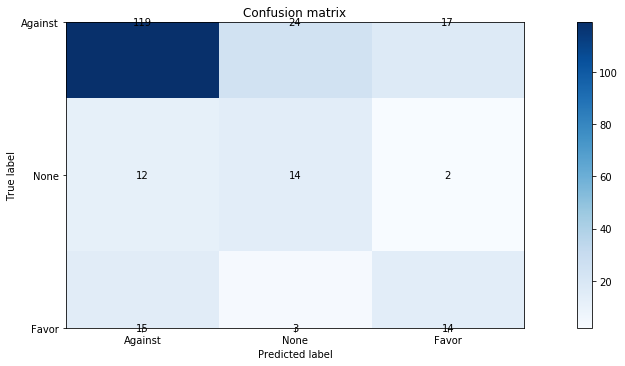

In [8]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors['default'], test_vectors['default'], ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6900200843811035
Prediction time: 0.1806490421295166
F1 score for Hillary 0.5040463534466534
              precision    recall  f1-score   support

     Against       0.68      0.78      0.73       172
        None       0.57      0.49      0.52        78
       Favor       0.31      0.22      0.26        45

   micro avg       0.62      0.62      0.62       295
   macro avg       0.52      0.50      0.50       295
weighted avg       0.60      0.62      0.60       295



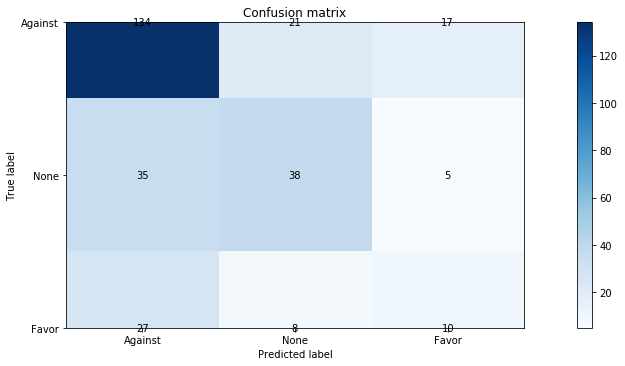

In [9]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors['default'], test_vectors['default'], ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.49745726585388184
Prediction time: 0.15373587608337402
F1 score for Abortion 0.5616856726482202
              precision    recall  f1-score   support

     Against       0.80      0.70      0.75       189
        None       0.35      0.53      0.42        45
       Favor       0.51      0.52      0.52        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.55      0.58      0.56       280
weighted avg       0.68      0.64      0.66       280



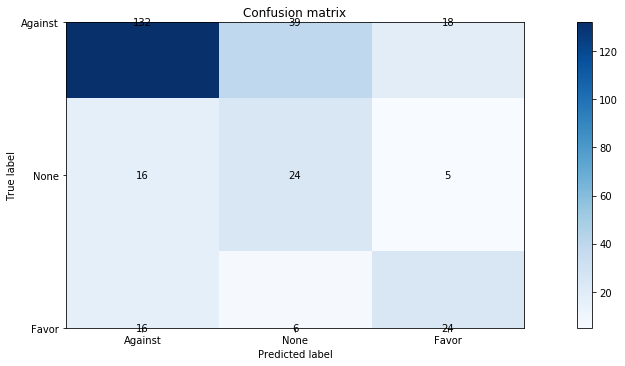

In [10]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors['default'], test_vectors['default'], 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.19653105735778809
Prediction time: 0.05499386787414551
F1 score for climate change 0.46602508019830857
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.54      0.57      0.56        35
       Favor       0.82      0.87      0.84       123

   micro avg       0.75      0.75      0.75       169
   macro avg       0.45      0.48      0.47       169
weighted avg       0.71      0.75      0.73       169



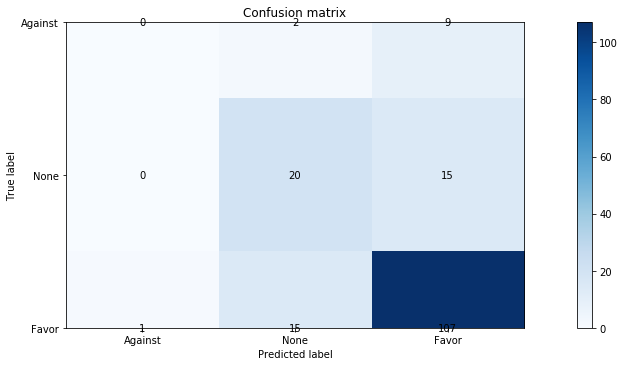

In [11]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors['default'], test_vectors['default'], 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6724720001220703
Prediction time: 0.17999577522277832
F1 score for feminist mov 0.4817255120007413
              precision    recall  f1-score   support

     Against       0.72      0.57      0.64       183
        None       0.41      0.41      0.41        44
       Favor       0.32      0.53      0.40        58

   micro avg       0.54      0.54      0.54       285
   macro avg       0.48      0.50      0.48       285
weighted avg       0.59      0.54      0.55       285



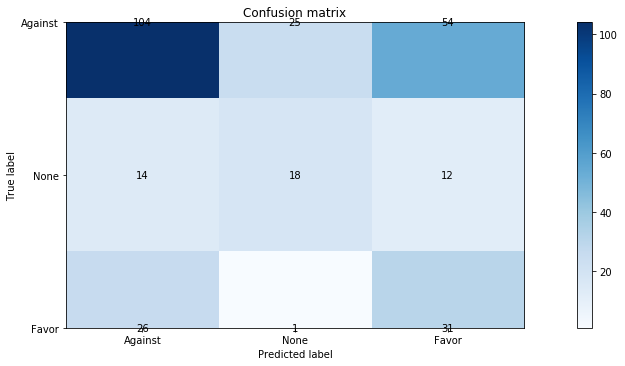

In [12]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors['default'], test_vectors['default'], 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 9.63976001739502
Prediction time: 2.8893818855285645
F1 score for all topics 0.5205991260533862
              precision    recall  f1-score   support

     Against       0.71      0.66      0.69       715
        None       0.39      0.46      0.42       230
       Favor       0.44      0.46      0.45       304

   micro avg       0.58      0.58      0.58      1249
   macro avg       0.52      0.53      0.52      1249
weighted avg       0.59      0.58      0.58      1249



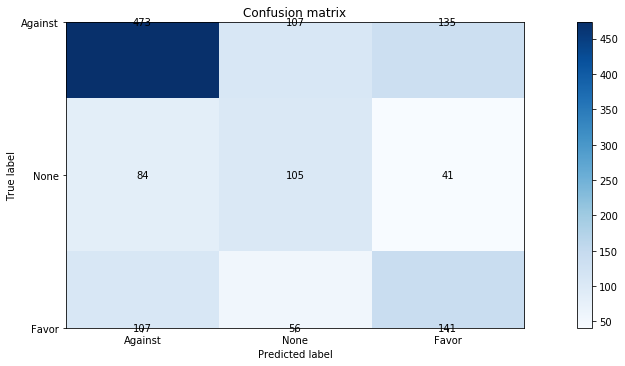

In [13]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors['default'], test_vectors['default'], all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

# Experiments with Elmo vector outputs

## 1A) - LSTM1 layer with Max pooling

Training time: 0.4044508934020996
Prediction time: 0.11301398277282715
F1 score for atheism: 0.5564639100673382
              precision    recall  f1-score   support

     Against       0.85      0.76      0.80       160
        None       0.40      0.61      0.49        28
       Favor       0.36      0.41      0.38        32

   micro avg       0.69      0.69      0.69       220
   macro avg       0.54      0.59      0.56       220
weighted avg       0.72      0.69      0.70       220



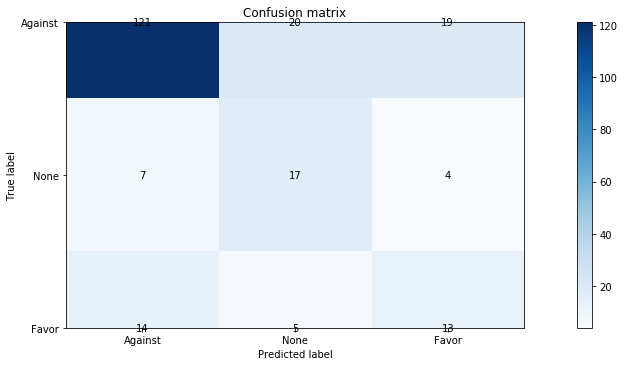

In [15]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7457787990570068
Prediction time: 0.20569872856140137
F1 score for Hillary 0.49065936200800403
              precision    recall  f1-score   support

     Against       0.65      0.76      0.70       172
        None       0.53      0.32      0.40        78
       Favor       0.36      0.38      0.37        45

   micro avg       0.59      0.59      0.59       295
   macro avg       0.52      0.49      0.49       295
weighted avg       0.58      0.59      0.57       295



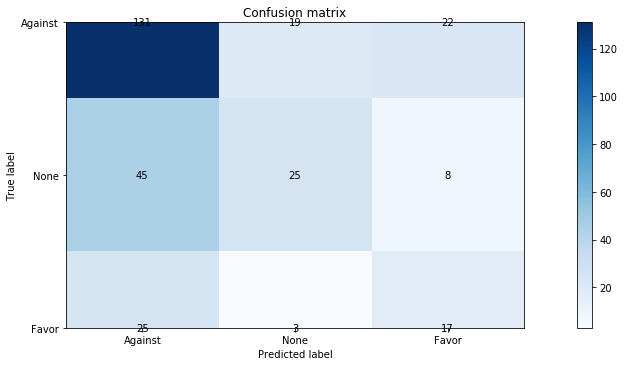

In [16]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6620709896087646
Prediction time: 0.17955875396728516
F1 score for Abortion 0.5487112154639392
              precision    recall  f1-score   support

     Against       0.78      0.71      0.75       189
        None       0.44      0.60      0.50        45
       Favor       0.40      0.39      0.40        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.54      0.57      0.55       280
weighted avg       0.66      0.64      0.65       280



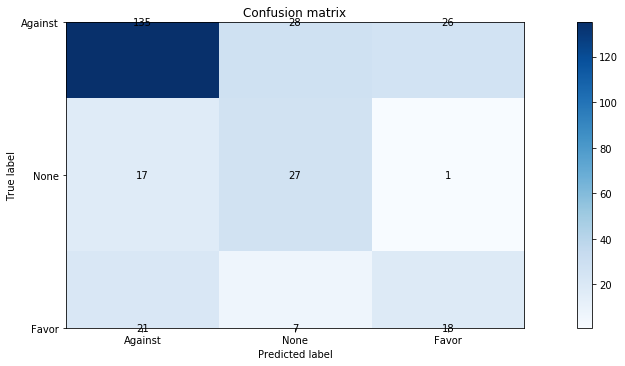

In [17]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.2253429889678955
Prediction time: 0.06601810455322266
F1 score for climate change 0.4862452297992368
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.53      0.71      0.61        35
       Favor       0.85      0.85      0.85       123

   micro avg       0.76      0.76      0.76       169
   macro avg       0.46      0.52      0.49       169
weighted avg       0.73      0.76      0.74       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


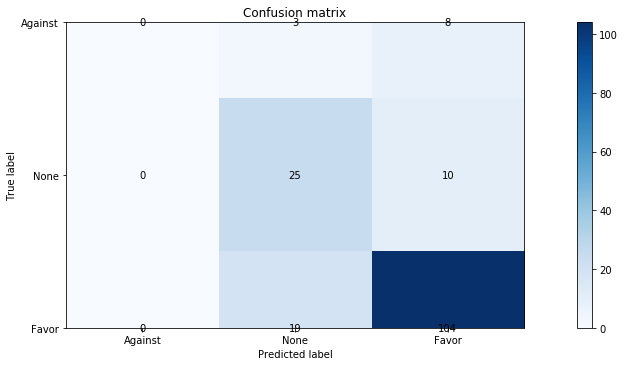

In [18]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6741070747375488
Prediction time: 0.19518399238586426
F1 score for feminist mov 0.4370119438032393
              precision    recall  f1-score   support

     Against       0.70      0.57      0.63       183
        None       0.32      0.27      0.29        44
       Favor       0.31      0.52      0.39        58

   micro avg       0.52      0.52      0.52       285
   macro avg       0.44      0.45      0.44       285
weighted avg       0.56      0.52      0.53       285



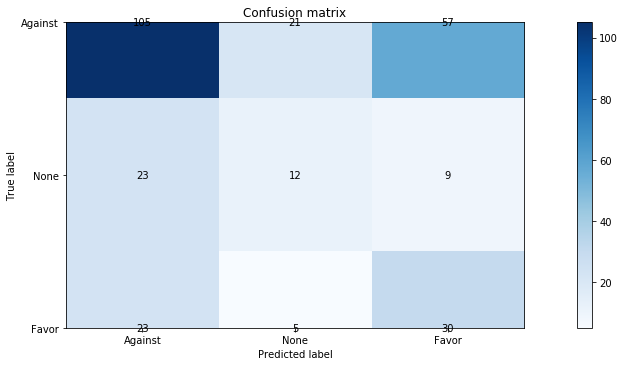

In [19]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 12.484747886657715
Prediction time: 2.840089797973633
F1 score for all topics 0.4460488071348682
              precision    recall  f1-score   support

     Against       0.63      0.59      0.61       715
        None       0.31      0.36      0.33       230
       Favor       0.38      0.40      0.39       304

   micro avg       0.50      0.50      0.50      1249
   macro avg       0.44      0.45      0.45      1249
weighted avg       0.51      0.50      0.51      1249



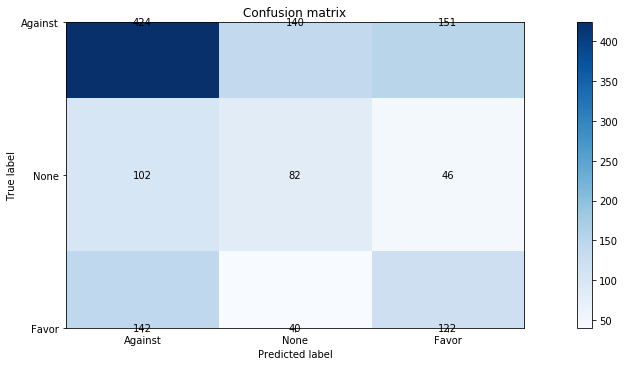

In [20]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 1B) - LSTM2 layer with Max pooling

In [21]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/lstm2_max_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/lstm2_max_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.4002249240875244
Prediction time: 0.10271406173706055
F1 score for atheism: 0.5406833603554916
              precision    recall  f1-score   support

     Against       0.83      0.75      0.79       160
        None       0.43      0.57      0.49        28
       Favor       0.32      0.38      0.34        32

   micro avg       0.67      0.67      0.67       220
   macro avg       0.53      0.57      0.54       220
weighted avg       0.70      0.67      0.68       220



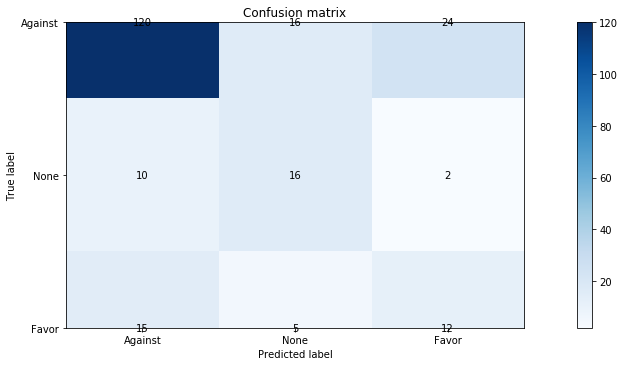

In [22]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7212717533111572
Prediction time: 0.18773293495178223
F1 score for Hillary 0.5452668473945069
              precision    recall  f1-score   support

     Against       0.69      0.81      0.74       172
        None       0.55      0.44      0.49        78
       Favor       0.52      0.33      0.41        45

   micro avg       0.64      0.64      0.64       295
   macro avg       0.58      0.53      0.55       295
weighted avg       0.62      0.64      0.62       295



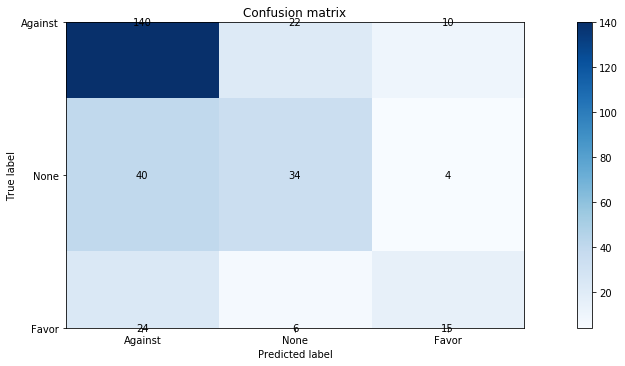

In [23]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6350550651550293
Prediction time: 0.1759021282196045
F1 score for Abortion 0.5336559001155274
              precision    recall  f1-score   support

     Against       0.80      0.66      0.72       189
        None       0.35      0.56      0.43        45
       Favor       0.42      0.48      0.45        46

   micro avg       0.61      0.61      0.61       280
   macro avg       0.52      0.57      0.53       280
weighted avg       0.67      0.61      0.63       280



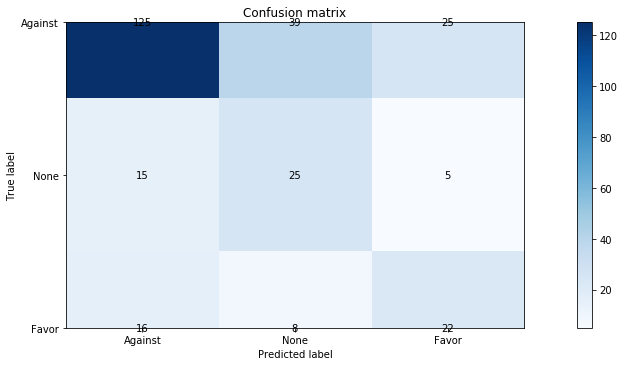

In [24]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.22636198997497559
Prediction time: 0.06473398208618164
F1 score for climate change 0.48329489061298664
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.56      0.66      0.61        35
       Favor       0.83      0.86      0.84       123

   micro avg       0.76      0.76      0.76       169
   macro avg       0.46      0.51      0.48       169
weighted avg       0.72      0.76      0.74       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


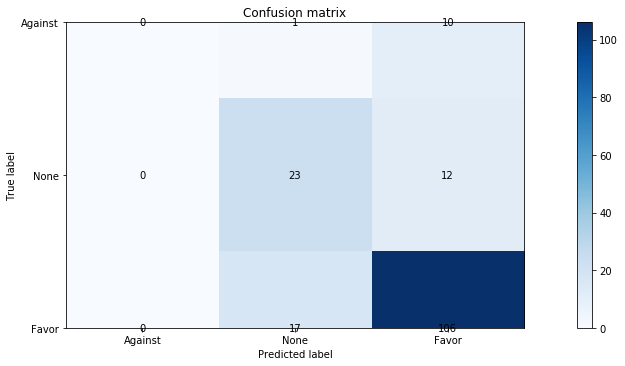

In [25]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6971828937530518
Prediction time: 0.20250988006591797
F1 score for feminist mov 0.46057331413960156
              precision    recall  f1-score   support

     Against       0.74      0.56      0.64       183
        None       0.39      0.41      0.40        44
       Favor       0.27      0.47      0.34        58

   micro avg       0.52      0.52      0.52       285
   macro avg       0.47      0.48      0.46       285
weighted avg       0.59      0.52      0.54       285



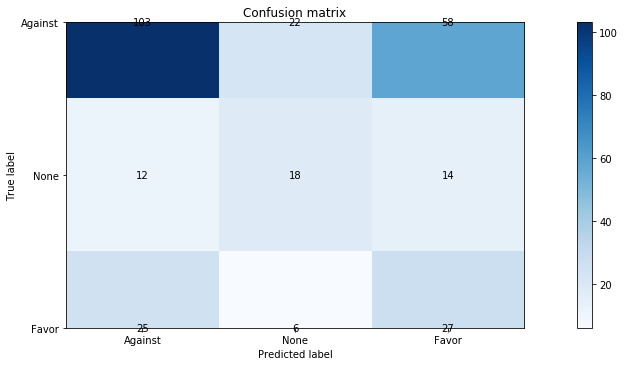

In [26]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 12.635447978973389
Prediction time: 2.7123188972473145
F1 score for all topics 0.4611546723952739
              precision    recall  f1-score   support

     Against       0.66      0.63      0.64       715
        None       0.33      0.37      0.35       230
       Favor       0.39      0.39      0.39       304

   micro avg       0.52      0.52      0.52      1249
   macro avg       0.46      0.46      0.46      1249
weighted avg       0.53      0.52      0.53      1249



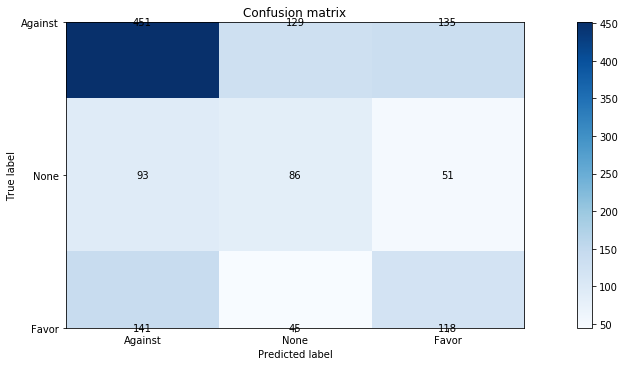

In [27]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 1C) - ELMO with Max pooling

In [28]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/elmo_max_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_max_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.40206265449523926
Prediction time: 0.10941100120544434
F1 score for atheism: 0.5159717475506949
              precision    recall  f1-score   support

     Against       0.83      0.75      0.79       160
        None       0.40      0.61      0.49        28
       Favor       0.26      0.28      0.27        32

   micro avg       0.66      0.66      0.66       220
   macro avg       0.50      0.55      0.52       220
weighted avg       0.70      0.66      0.68       220



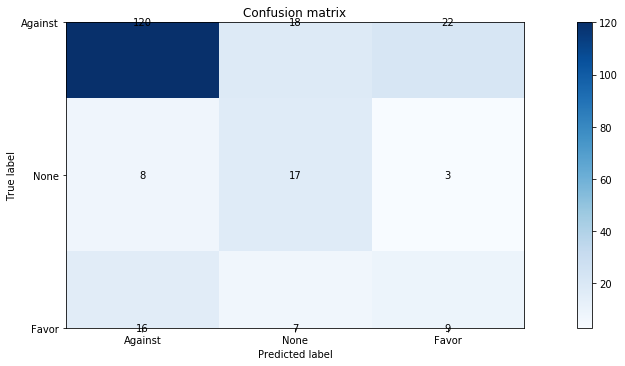

In [29]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7473609447479248
Prediction time: 0.20013070106506348
F1 score for Hillary 0.5539145097170426
              precision    recall  f1-score   support

     Against       0.69      0.80      0.74       172
        None       0.54      0.47      0.51        78
       Favor       0.54      0.33      0.41        45

   micro avg       0.64      0.64      0.64       295
   macro avg       0.59      0.54      0.55       295
weighted avg       0.63      0.64      0.63       295



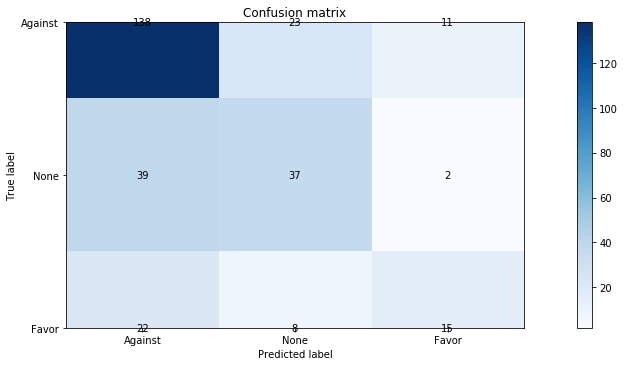

In [30]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6447353363037109
Prediction time: 0.17530298233032227
F1 score for Abortion 0.5420658764800254
              precision    recall  f1-score   support

     Against       0.79      0.69      0.73       189
        None       0.37      0.58      0.45        45
       Favor       0.44      0.43      0.44        46

   micro avg       0.63      0.63      0.63       280
   macro avg       0.53      0.57      0.54       280
weighted avg       0.66      0.63      0.64       280



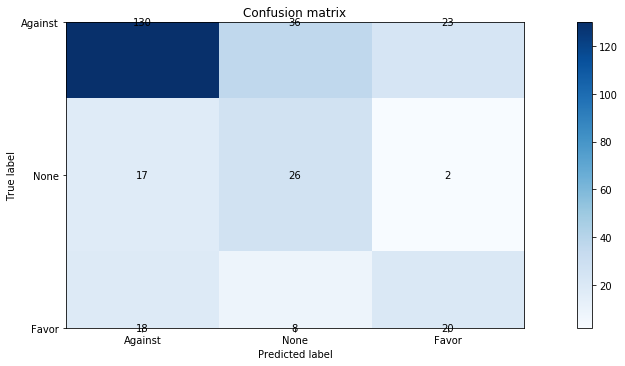

In [31]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.2142021656036377
Prediction time: 0.0671699047088623
F1 score for climate change 0.4365721997300945
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.44      0.57      0.50        35
       Favor       0.81      0.81      0.81       123

   micro avg       0.71      0.71      0.71       169
   macro avg       0.42      0.46      0.44       169
weighted avg       0.68      0.71      0.69       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


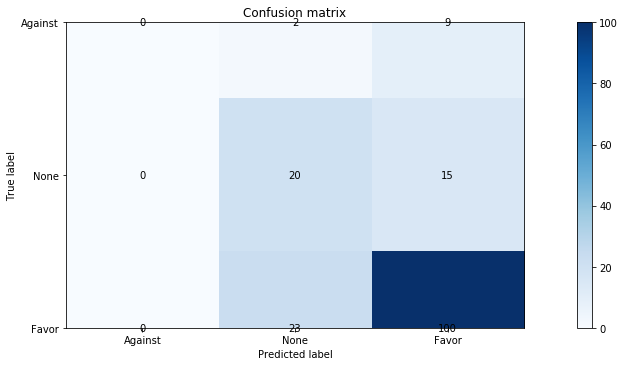

In [32]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6807150840759277
Prediction time: 0.1849818229675293
F1 score for feminist mov 0.43088172109545825
              precision    recall  f1-score   support

     Against       0.69      0.52      0.59       183
        None       0.37      0.32      0.34        44
       Favor       0.28      0.52      0.36        58

   micro avg       0.49      0.49      0.49       285
   macro avg       0.44      0.45      0.43       285
weighted avg       0.55      0.49      0.51       285



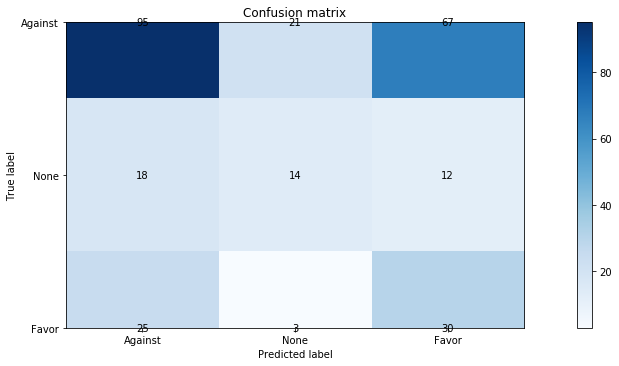

In [33]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 10.510454893112183
Prediction time: 2.85699200630188
F1 score for all topics 0.46729366586776333
              precision    recall  f1-score   support

     Against       0.66      0.63      0.65       715
        None       0.33      0.40      0.36       230
       Favor       0.40      0.38      0.39       304

   micro avg       0.53      0.53      0.53      1249
   macro avg       0.47      0.47      0.47      1249
weighted avg       0.54      0.53      0.53      1249



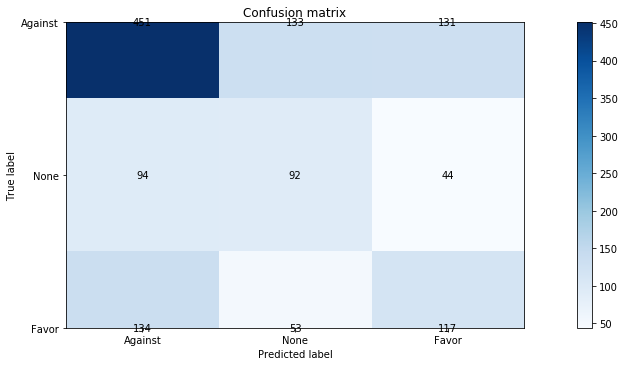

In [34]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 2A) - LSTM1 with Min pooling

In [35]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/lstm1_min_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/lstm1_min_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.42328596115112305
Prediction time: 0.11090898513793945
F1 score for atheism: 0.48246795406904486
              precision    recall  f1-score   support

     Against       0.80      0.71      0.75       160
        None       0.38      0.57      0.46        28
       Favor       0.22      0.25      0.24        32

   micro avg       0.63      0.63      0.63       220
   macro avg       0.47      0.51      0.48       220
weighted avg       0.66      0.63      0.64       220



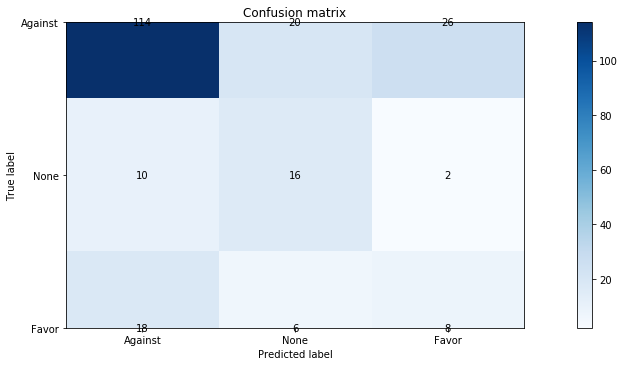

In [36]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7327709197998047
Prediction time: 0.202347993850708
F1 score for Hillary 0.4208317849622197
              precision    recall  f1-score   support

     Against       0.63      0.72      0.67       172
        None       0.42      0.36      0.39        78
       Favor       0.24      0.18      0.21        45

   micro avg       0.54      0.54      0.54       295
   macro avg       0.43      0.42      0.42       295
weighted avg       0.52      0.54      0.52       295



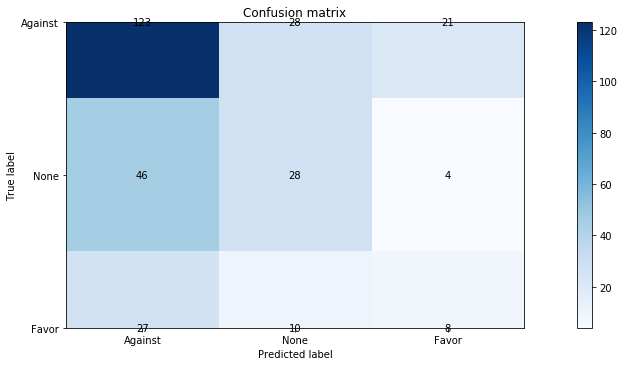

In [37]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.666945219039917
Prediction time: 0.1805438995361328
F1 score for Abortion 0.5011284456132237
              precision    recall  f1-score   support

     Against       0.75      0.66      0.70       189
        None       0.35      0.49      0.41        45
       Favor       0.37      0.41      0.39        46

   micro avg       0.59      0.59      0.59       280
   macro avg       0.49      0.52      0.50       280
weighted avg       0.63      0.59      0.61       280



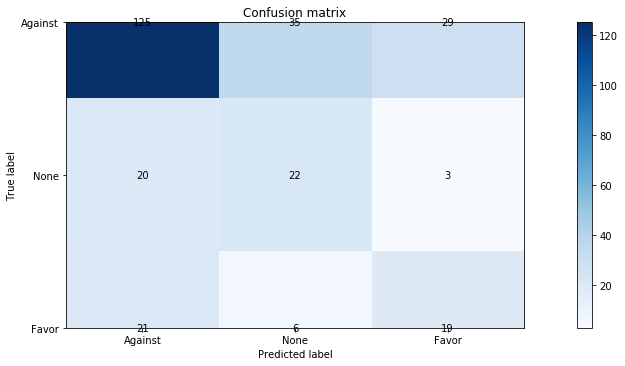

In [38]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.21291112899780273
Prediction time: 0.061842918395996094
F1 score for climate change 0.40768201009164867
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.40      0.49      0.44        35
       Favor       0.78      0.80      0.79       123

   micro avg       0.68      0.68      0.68       169
   macro avg       0.39      0.43      0.41       169
weighted avg       0.65      0.68      0.66       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


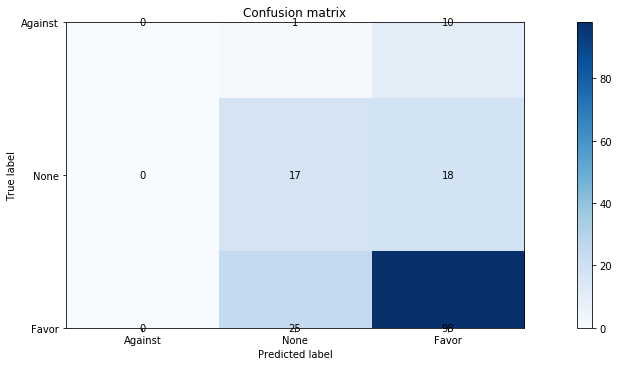

In [39]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6734631061553955
Prediction time: 0.18603897094726562
F1 score for feminist mov 0.5247852585356336
              precision    recall  f1-score   support

     Against       0.76      0.64      0.69       183
        None       0.44      0.45      0.45        44
       Favor       0.36      0.53      0.43        58

   micro avg       0.59      0.59      0.59       285
   macro avg       0.52      0.54      0.52       285
weighted avg       0.63      0.59      0.60       285



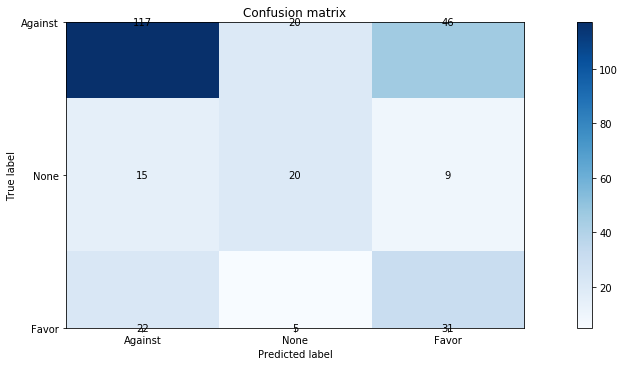

In [40]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 12.475378274917603
Prediction time: 2.7751519680023193
F1 score for all topics 0.43014866294964177
              precision    recall  f1-score   support

     Against       0.66      0.58      0.62       715
        None       0.30      0.40      0.34       230
       Favor       0.33      0.34      0.34       304

   micro avg       0.49      0.49      0.49      1249
   macro avg       0.43      0.44      0.43      1249
weighted avg       0.51      0.49      0.50      1249



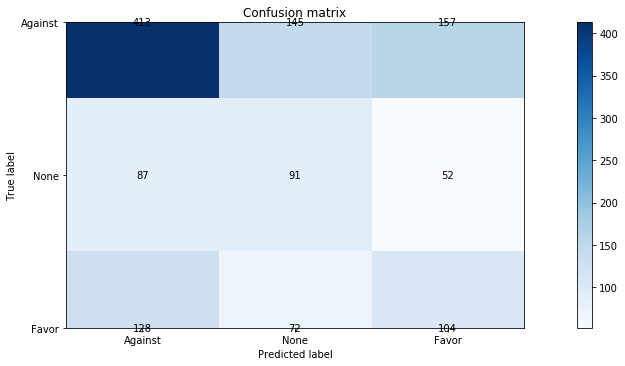

In [41]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 2B) - LSTM2 with Min pooling

In [42]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/lstm2_min_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/lstm2_min_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.4522209167480469
Prediction time: 0.11220598220825195
F1 score for atheism: 0.4930209751408128
              precision    recall  f1-score   support

     Against       0.80      0.68      0.73       160
        None       0.35      0.54      0.42        28
       Favor       0.29      0.38      0.32        32

   micro avg       0.61      0.61      0.61       220
   macro avg       0.48      0.53      0.49       220
weighted avg       0.67      0.61      0.63       220



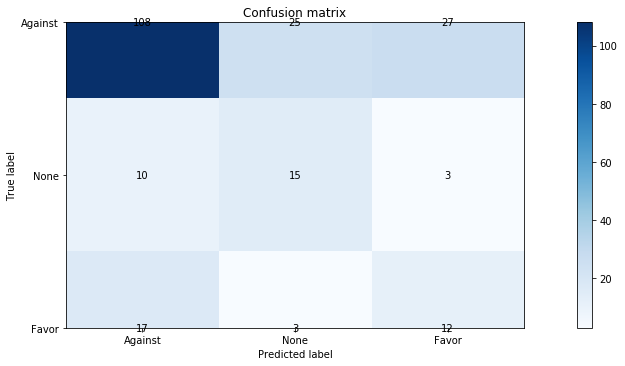

In [43]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7196071147918701
Prediction time: 0.19290781021118164
F1 score for Hillary 0.5163575985884389
              precision    recall  f1-score   support

     Against       0.68      0.77      0.72       172
        None       0.54      0.42      0.47        78
       Favor       0.38      0.33      0.35        45

   micro avg       0.61      0.61      0.61       295
   macro avg       0.53      0.51      0.52       295
weighted avg       0.60      0.61      0.60       295



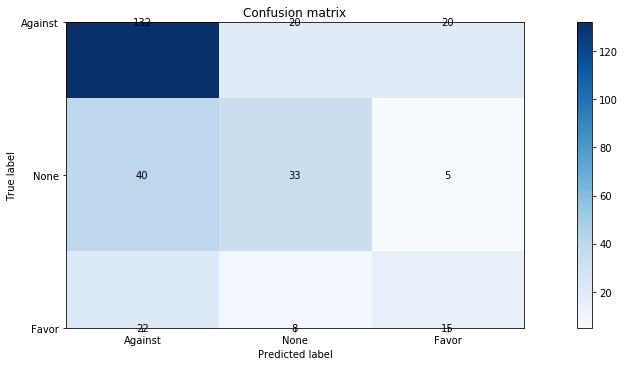

In [44]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6203799247741699
Prediction time: 0.17431306838989258
F1 score for Abortion 0.525737833201997
              precision    recall  f1-score   support

     Against       0.79      0.65      0.71       189
        None       0.34      0.62      0.44        45
       Favor       0.44      0.41      0.43        46

   micro avg       0.60      0.60      0.60       280
   macro avg       0.52      0.56      0.53       280
weighted avg       0.66      0.60      0.62       280



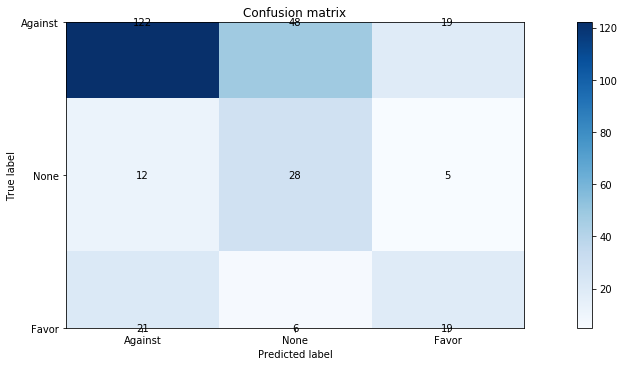

In [45]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.21021509170532227
Prediction time: 0.06190180778503418
F1 score for climate change 0.4637020566981656
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.54      0.54      0.54        35
       Favor       0.81      0.89      0.85       123

   micro avg       0.76      0.76      0.76       169
   macro avg       0.45      0.48      0.46       169
weighted avg       0.70      0.76      0.73       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


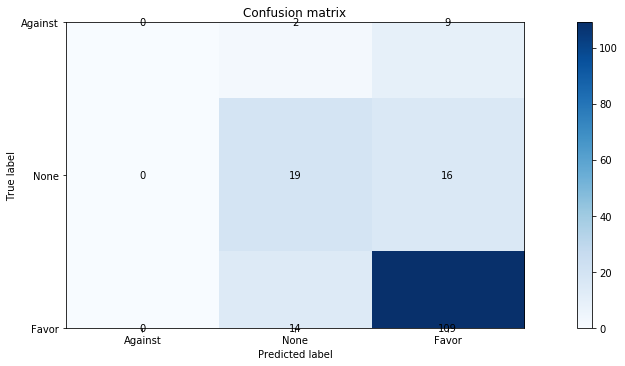

In [46]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6766042709350586
Prediction time: 0.18960213661193848
F1 score for feminist mov 0.5019202553449128
              precision    recall  f1-score   support

     Against       0.73      0.60      0.66       183
        None       0.45      0.48      0.46        44
       Favor       0.32      0.48      0.38        58

   micro avg       0.56      0.56      0.56       285
   macro avg       0.50      0.52      0.50       285
weighted avg       0.60      0.56      0.57       285



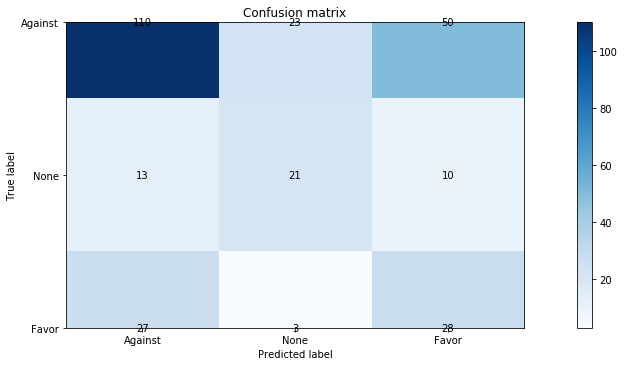

In [47]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 11.655312776565552
Prediction time: 2.6744120121002197
F1 score for all topics 0.450100044417064
              precision    recall  f1-score   support

     Against       0.65      0.60      0.62       715
        None       0.31      0.38      0.34       230
       Favor       0.38      0.38      0.38       304

   micro avg       0.51      0.51      0.51      1249
   macro avg       0.45      0.46      0.45      1249
weighted avg       0.52      0.51      0.51      1249



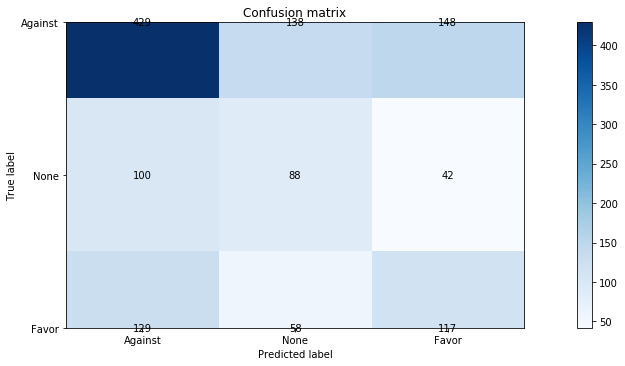

In [48]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 2C) - ELMO with Min pooling

In [49]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/elmo_min_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_min_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.40492892265319824
Prediction time: 0.10265684127807617
F1 score for atheism: 0.5683627524478067
              precision    recall  f1-score   support

     Against       0.84      0.74      0.79       160
        None       0.44      0.61      0.51        28
       Favor       0.37      0.47      0.41        32

   micro avg       0.68      0.68      0.68       220
   macro avg       0.55      0.60      0.57       220
weighted avg       0.72      0.68      0.70       220



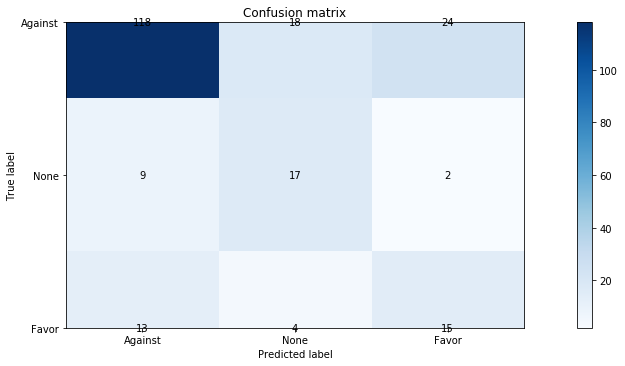

In [50]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.8168039321899414
Prediction time: 0.22055768966674805
F1 score for Hillary 0.4900592661668448
              precision    recall  f1-score   support

     Against       0.67      0.76      0.71       172
        None       0.51      0.38      0.44        78
       Favor       0.33      0.31      0.32        45

   micro avg       0.59      0.59      0.59       295
   macro avg       0.50      0.48      0.49       295
weighted avg       0.58      0.59      0.58       295



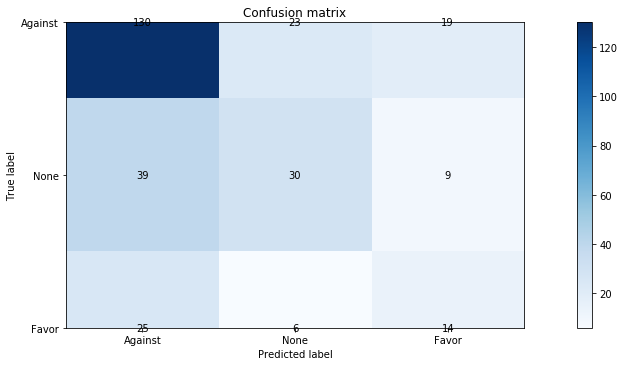

In [51]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7116427421569824
Prediction time: 0.18861699104309082
F1 score for Abortion 0.4673409177555194
              precision    recall  f1-score   support

     Against       0.73      0.63      0.68       189
        None       0.30      0.51      0.38        45
       Favor       0.38      0.33      0.35        46

   micro avg       0.56      0.56      0.56       280
   macro avg       0.47      0.49      0.47       280
weighted avg       0.60      0.56      0.57       280



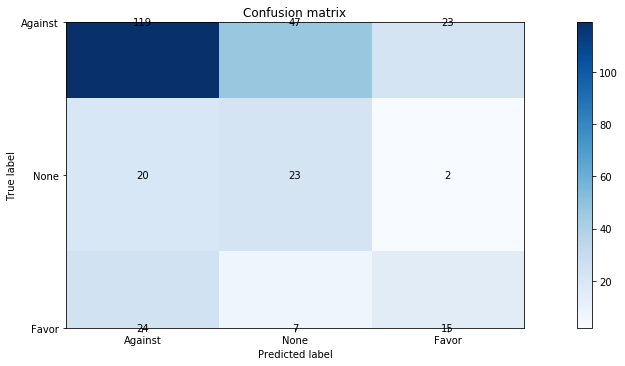

In [52]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.2643740177154541
Prediction time: 0.06592988967895508
F1 score for climate change 0.44516017316017314
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.48      0.57      0.52        35
       Favor       0.80      0.83      0.82       123

   micro avg       0.72      0.72      0.72       169
   macro avg       0.43      0.47      0.45       169
weighted avg       0.68      0.72      0.70       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


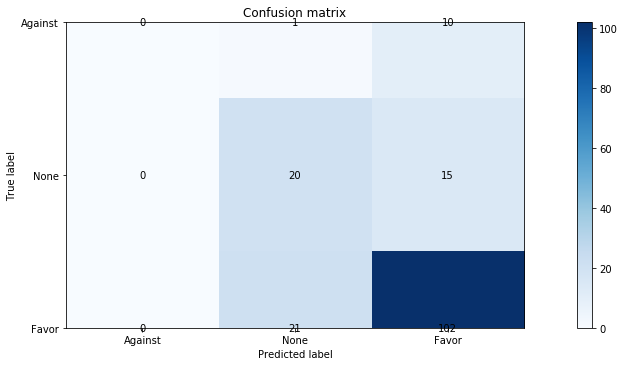

In [53]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7044200897216797
Prediction time: 0.22484707832336426
F1 score for feminist mov 0.5047753063701927
              precision    recall  f1-score   support

     Against       0.75      0.64      0.69       183
        None       0.42      0.41      0.41        44
       Favor       0.35      0.50      0.41        58

   micro avg       0.58      0.58      0.58       285
   macro avg       0.50      0.52      0.50       285
weighted avg       0.61      0.58      0.59       285



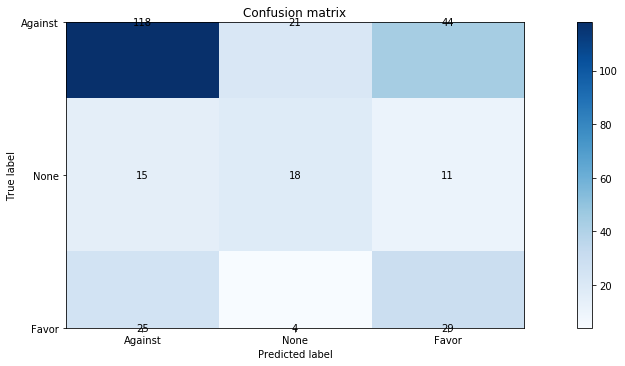

In [54]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 10.394003868103027
Prediction time: 2.7791781425476074
F1 score for all topics 0.4547322684588782
              precision    recall  f1-score   support

     Against       0.66      0.58      0.61       715
        None       0.32      0.38      0.35       230
       Favor       0.37      0.43      0.40       304

   micro avg       0.51      0.51      0.51      1249
   macro avg       0.45      0.46      0.45      1249
weighted avg       0.53      0.51      0.51      1249



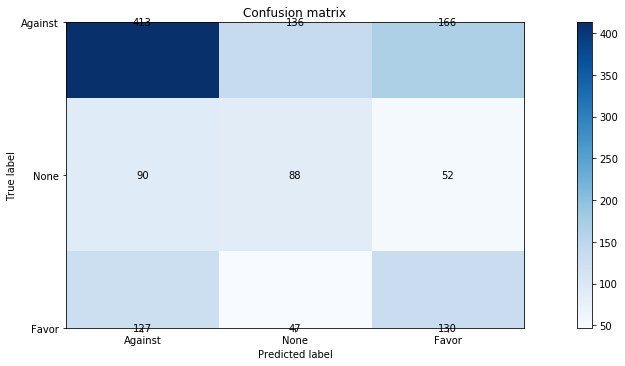

In [55]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 3A) LSTM1 layer; Mean pooling

In [56]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/lstm1_mean_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/lstm1_mean_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.2770531177520752
Prediction time: 0.09341955184936523
F1 score for atheism: 0.5659998300865625
              precision    recall  f1-score   support

     Against       0.83      0.76      0.79       160
        None       0.45      0.61      0.52        28
       Favor       0.37      0.41      0.39        32

   micro avg       0.69      0.69      0.69       220
   macro avg       0.55      0.59      0.57       220
weighted avg       0.71      0.69      0.70       220



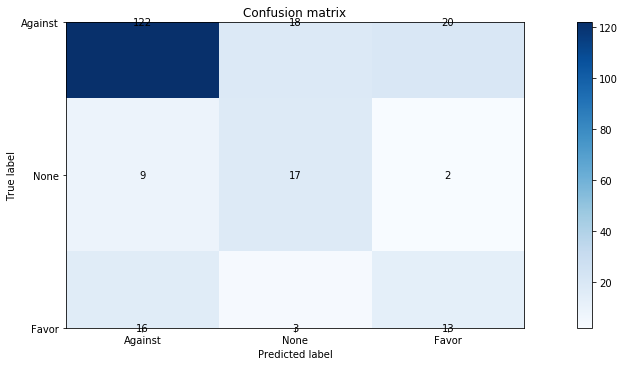

In [57]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.5335171222686768
Prediction time: 0.181074857711792
F1 score for Hillary 0.5538372040989844
              precision    recall  f1-score   support

     Against       0.68      0.83      0.75       172
        None       0.69      0.46      0.55        78
       Favor       0.42      0.31      0.36        45

   micro avg       0.65      0.65      0.65       295
   macro avg       0.60      0.53      0.55       295
weighted avg       0.64      0.65      0.64       295



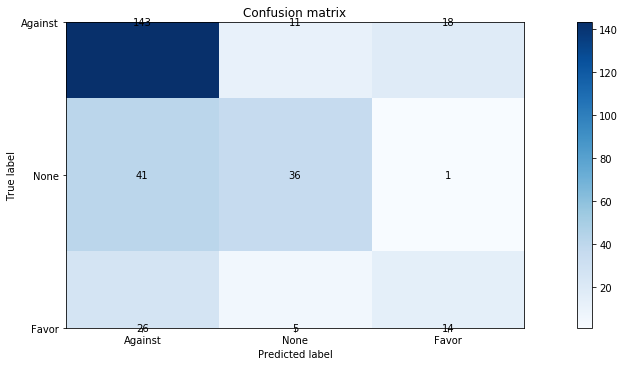

In [58]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.45206403732299805
Prediction time: 0.16051411628723145
F1 score for Abortion 0.5702379861192951
              precision    recall  f1-score   support

     Against       0.80      0.75      0.77       189
        None       0.45      0.64      0.53        45
       Favor       0.45      0.37      0.40        46

   micro avg       0.67      0.67      0.67       280
   macro avg       0.57      0.59      0.57       280
weighted avg       0.68      0.67      0.67       280



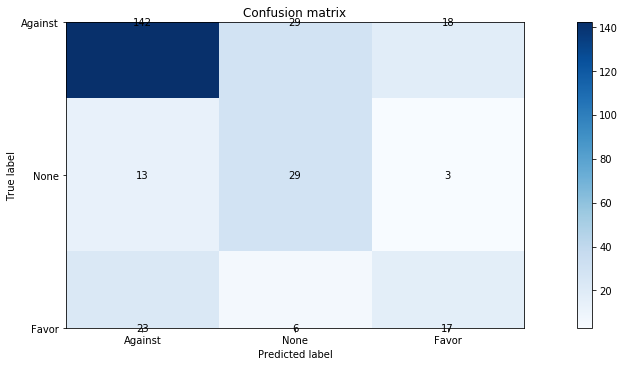

In [59]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.1910557746887207
Prediction time: 0.05592012405395508
F1 score for climate change 0.4493872927607867
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.47      0.57      0.51        35
       Favor       0.83      0.85      0.84       123

   micro avg       0.73      0.73      0.73       169
   macro avg       0.43      0.47      0.45       169
weighted avg       0.70      0.73      0.71       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


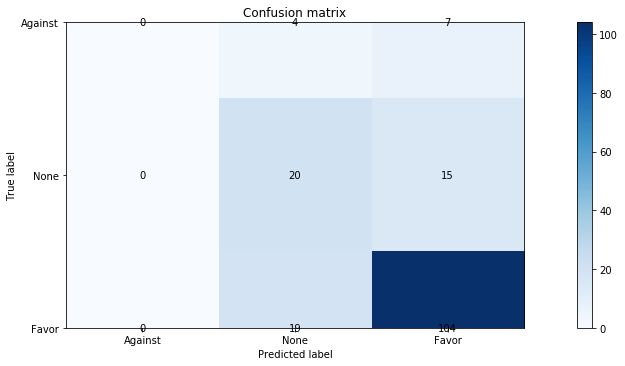

In [60]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6163041591644287
Prediction time: 0.18876075744628906
F1 score for feminist mov 0.5067877798619628
              precision    recall  f1-score   support

     Against       0.74      0.55      0.63       183
        None       0.51      0.45      0.48        44
       Favor       0.31      0.59      0.41        58

   micro avg       0.54      0.54      0.54       285
   macro avg       0.52      0.53      0.51       285
weighted avg       0.62      0.54      0.56       285



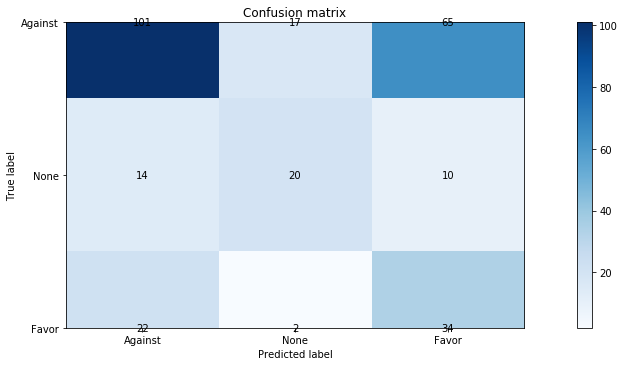

In [61]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 9.39037537574768
Prediction time: 3.2129740715026855
F1 score for all topics 0.5158657811174603
              precision    recall  f1-score   support

     Against       0.68      0.67      0.68       715
        None       0.40      0.44      0.42       230
       Favor       0.45      0.44      0.45       304

   micro avg       0.57      0.57      0.57      1249
   macro avg       0.51      0.52      0.52      1249
weighted avg       0.58      0.57      0.58      1249



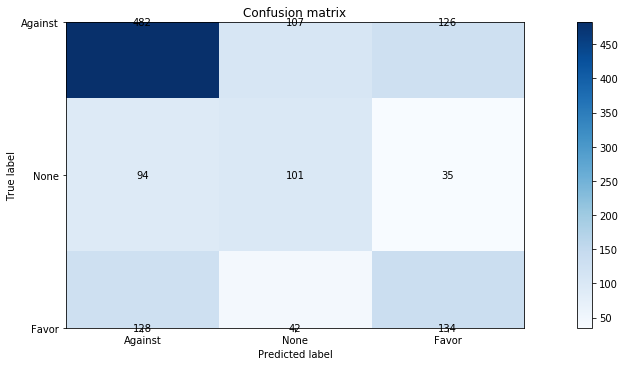

In [62]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 3B) LSTM2 Layer; Mean pooling

In [63]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/lstm2_mean_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/lstm2_mean_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.30846714973449707
Prediction time: 0.09211921691894531
F1 score for atheism: 0.5619354220561464
              precision    recall  f1-score   support

     Against       0.83      0.69      0.76       160
        None       0.37      0.57      0.45        28
       Favor       0.42      0.56      0.48        32

   micro avg       0.66      0.66      0.66       220
   macro avg       0.54      0.61      0.56       220
weighted avg       0.71      0.66      0.68       220



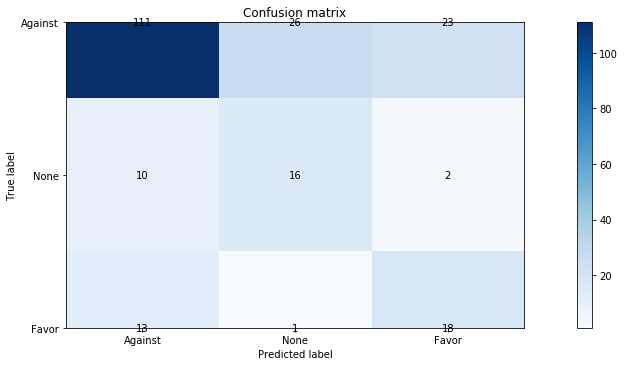

In [64]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.590123176574707
Prediction time: 0.1693556308746338
F1 score for Hillary 0.5280527072964003
              precision    recall  f1-score   support

     Against       0.72      0.77      0.74       172
        None       0.59      0.55      0.57        78
       Favor       0.31      0.24      0.27        45

   micro avg       0.63      0.63      0.63       295
   macro avg       0.54      0.52      0.53       295
weighted avg       0.62      0.63      0.63       295



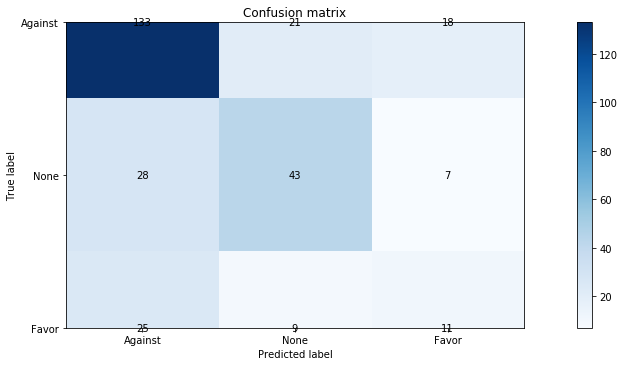

In [65]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.4263620376586914
Prediction time: 0.14728784561157227
F1 score for Abortion 0.5710394802598701
              precision    recall  f1-score   support

     Against       0.81      0.68      0.74       189
        None       0.36      0.60      0.45        45
       Favor       0.52      0.52      0.52        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.56      0.60      0.57       280
weighted avg       0.69      0.64      0.66       280



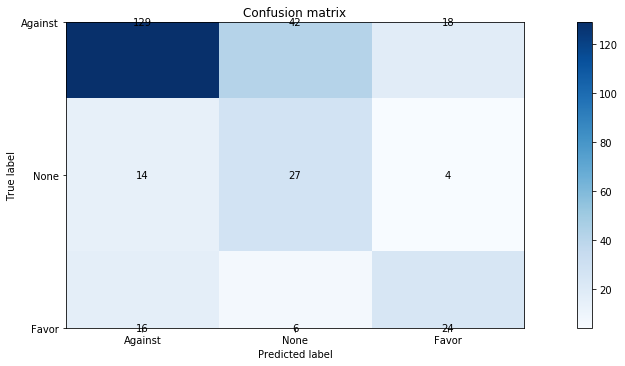

In [66]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.1853940486907959
Prediction time: 0.05316615104675293
F1 score for climate change 0.526809148856393
              precision    recall  f1-score   support

     Against       0.33      0.09      0.14        11
        None       0.57      0.57      0.57        35
       Favor       0.84      0.89      0.87       123

   micro avg       0.78      0.78      0.78       169
   macro avg       0.58      0.52      0.53       169
weighted avg       0.75      0.78      0.76       169



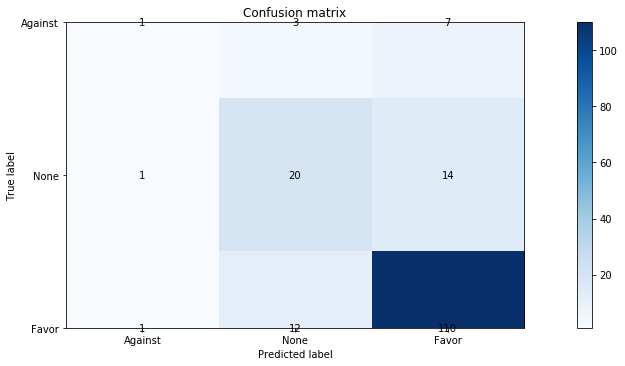

In [67]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6519198417663574
Prediction time: 0.1668989658355713
F1 score for feminist mov 0.48140178630623714
              precision    recall  f1-score   support

     Against       0.73      0.58      0.65       183
        None       0.39      0.43      0.41        44
       Favor       0.32      0.50      0.39        58

   micro avg       0.54      0.54      0.54       285
   macro avg       0.48      0.50      0.48       285
weighted avg       0.59      0.54      0.56       285



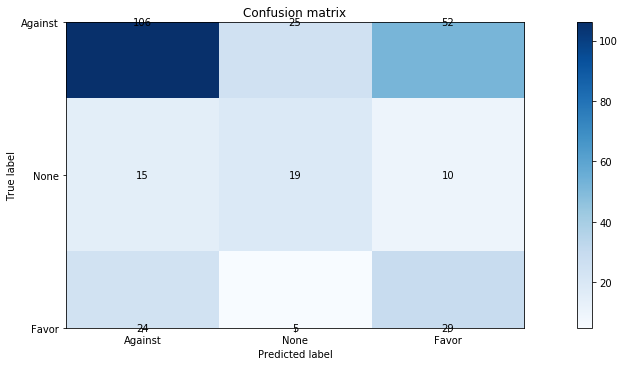

In [68]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 10.599329948425293
Prediction time: 2.9280292987823486
F1 score for all topics 0.4996338189886576
              precision    recall  f1-score   support

     Against       0.70      0.64      0.67       715
        None       0.35      0.42      0.38       230
       Favor       0.44      0.47      0.45       304

   micro avg       0.55      0.55      0.55      1249
   macro avg       0.50      0.51      0.50      1249
weighted avg       0.57      0.55      0.56      1249



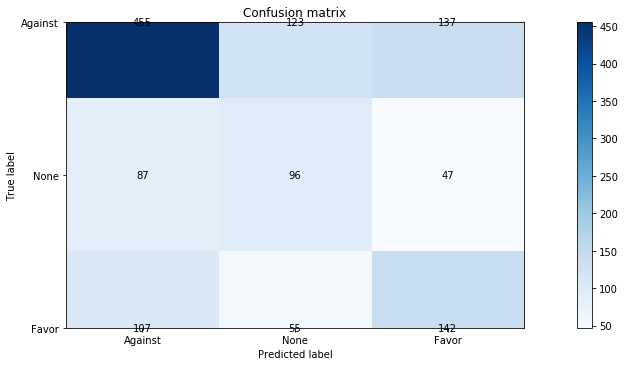

In [69]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

## 3C) ELMO Layer; Mean pooling

In [70]:
# Load relevant pickle files 
with open("./ELMO Outputs v.2/elmo_mean_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_mean_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

Training time: 0.2641479969024658
Prediction time: 0.08972287178039551
F1 score for atheism: 0.5404689837525659
              precision    recall  f1-score   support

     Against       0.80      0.74      0.77       160
        None       0.36      0.50      0.42        28
       Favor       0.42      0.44      0.43        32

   micro avg       0.67      0.67      0.67       220
   macro avg       0.53      0.56      0.54       220
weighted avg       0.69      0.67      0.68       220



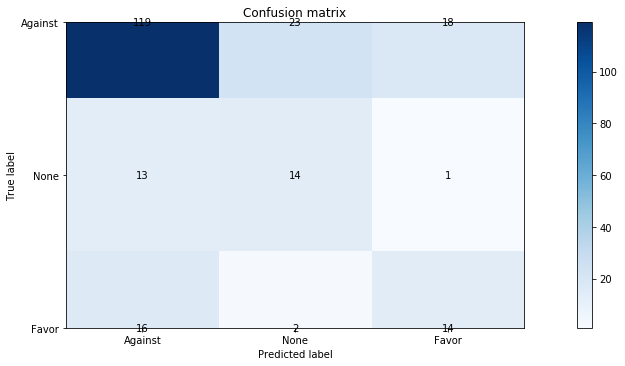

In [71]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'])
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.4998960494995117
Prediction time: 0.1799020767211914
F1 score for Hillary 0.5285651285651286
              precision    recall  f1-score   support

     Against       0.69      0.80      0.74       172
        None       0.62      0.51      0.56        78
       Favor       0.34      0.24      0.29        45

   micro avg       0.64      0.64      0.64       295
   macro avg       0.55      0.52      0.53       295
weighted avg       0.62      0.64      0.62       295



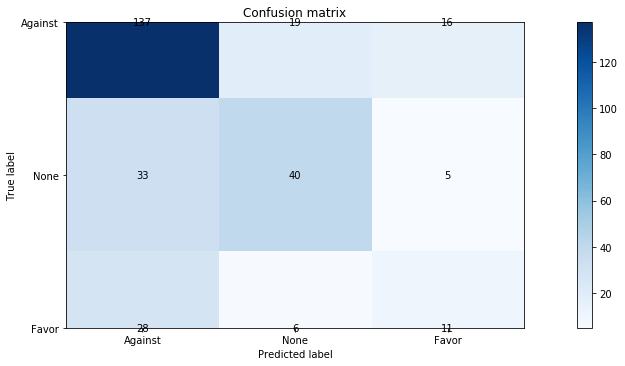

In [72]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'])
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.4295380115509033
Prediction time: 0.1538691520690918
F1 score for Abortion 0.5633269932959976
              precision    recall  f1-score   support

     Against       0.80      0.70      0.75       189
        None       0.38      0.60      0.47        45
       Favor       0.50      0.46      0.48        46

   micro avg       0.65      0.65      0.65       280
   macro avg       0.56      0.59      0.56       280
weighted avg       0.68      0.65      0.66       280



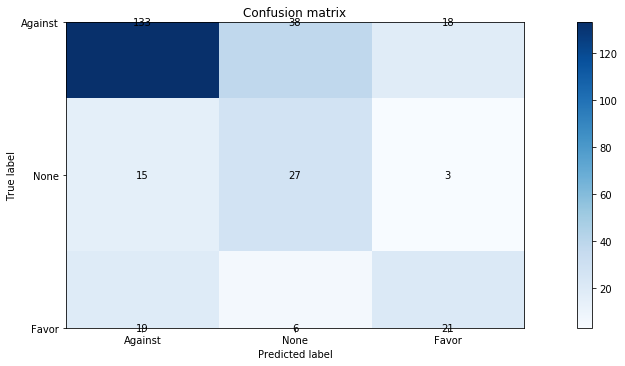

In [73]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, 
                                                 ['Legalization of Abortion'])
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.18034076690673828
Prediction time: 0.05634593963623047
F1 score for climate change 0.5388120651278546
              precision    recall  f1-score   support

     Against       0.33      0.09      0.14        11
        None       0.57      0.69      0.62        35
       Favor       0.85      0.85      0.85       123

   micro avg       0.77      0.77      0.77       169
   macro avg       0.58      0.54      0.54       169
weighted avg       0.76      0.77      0.76       169



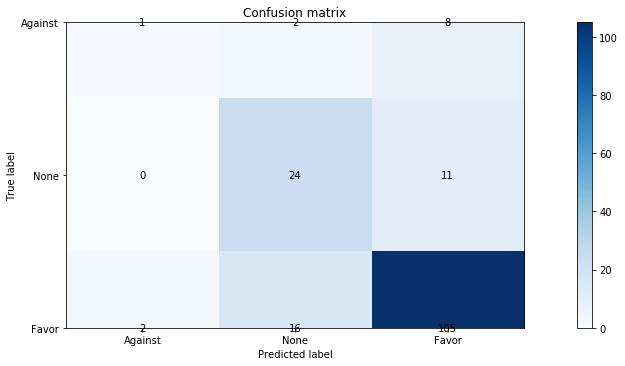

In [74]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, 
                                              ['Climate Change is a Real Concern'])
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.539921760559082
Prediction time: 0.17827510833740234
F1 score for feminist mov 0.514469808429819
              precision    recall  f1-score   support

     Against       0.74      0.58      0.65       183
        None       0.49      0.45      0.47        44
       Favor       0.33      0.57      0.42        58

   micro avg       0.56      0.56      0.56       285
   macro avg       0.52      0.54      0.51       285
weighted avg       0.62      0.56      0.58       285



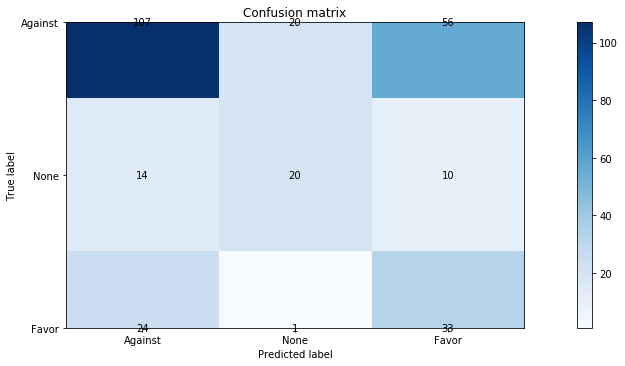

In [75]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, 
                                           ['Feminist Movement'])
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 9.47081208229065
Prediction time: 3.1856791973114014
F1 score for all topics 0.5404903145806284
              precision    recall  f1-score   support

     Against       0.72      0.67      0.70       715
        None       0.40      0.50      0.44       230
       Favor       0.49      0.47      0.48       304

   micro avg       0.59      0.59      0.59      1249
   macro avg       0.54      0.55      0.54      1249
weighted avg       0.61      0.59      0.60      1249



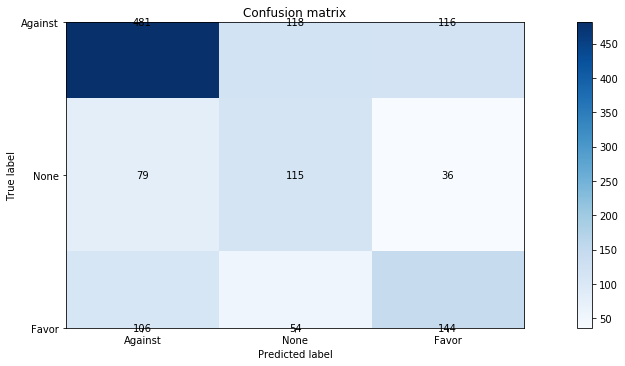

In [76]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops)
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()

# 3 - Outputs

In [ ]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
# Histograms of predicted probabilities
def class_prob_breakdown(model_results):
    plt.figure(figsize=(20, 10))

    plt.subplot(2,3,1)
    plt.title("Prob. Dist. - Predicted Against")
    plt.hist([item[0] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,2)
    plt.title("Prob. Dist. - Predicted None")
    plt.hist([item[1] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,3)
    plt.title("Prob. Dist. - Predicted Favor")
    plt.hist([item[2] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,4)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.subplot(2,3,5)
    plt.title("Prob. Dist. - Probability None, by True Label")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")
    
    plt.subplot(2,3,6)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.show()
    
def standard_output(model_results):
    # Class Weights
    plt.subplot(1,2,1)
    model_results['train_names'].value_counts().plot(kind='bar', title = "Class Distribution - Train")
    plt.subplot(1,2,2)
    model_results['test_true_names'].value_counts().plot(kind='bar', title = "Class Distribution - Test")
    # Classification Report
    print(metrics.classification_report(y_true = model_results['test_true_labels'], 
                                        y_pred = model_results['test_predict'],
                                        target_names = ['Against', 'None', 'Favor']))
    # Confusion Matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    confusion_plot(confusion_matrix = metrics.confusion_matrix(y_true = model_results['test_true_labels'], 
                                                               y_pred = model_results['test_predict']), 
                   target_names = ['Against', 'None', 'Favor'])
    # Class probability breakdown
    class_prob_breakdown(model_results = model_results)